# Time-Series Modeling Lesson with Stock Data
### Kwame V. Taylor

In [53]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# default viz settings
plt.rc('figure', figsize=(14, 11))
plt.rc('font', size=15)
plt.rc('lines', linewidth=2, c='m')
plt.style.use('seaborn-whitegrid')

### Acquire and prepare the stock data.

In [26]:
# get stock data
from vega_datasets import data
stocks = data.stocks()
# to transform such that each symbol is it's own column and each row is one month
stocks.pivot_table('price', 'date', 'symbol')

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45
...,...,...,...,...,...
2009-11-01,199.91,135.91,583.00,125.79,29.27
2009-12-01,210.73,134.52,619.98,130.32,30.34
2010-01-01,192.06,125.41,529.94,121.85,28.05


I just want to focus on IBM.

In [27]:
IBM = pd.DataFrame(stocks[stocks['symbol'] == 'IBM'])
IBM = stocks.pivot_table('price', 'date')
IBM

,price
date,
2000-01-01,57.7075
2000-02-01,56.4975
2000-03-01,62.5700
2000-04-01,53.6300
2000-05-01,47.7675
...,...
2009-11-01,214.7760
2009-12-01,225.1780
2010-01-01,199.4620


In [28]:
IBM.isna().sum()

price    0
dtype: int64

In [41]:
IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


I'll remove leap days later if I have time.

### Split the data

In [31]:
train_size = int(len(IBM) * .5)
train_size

61

In [32]:
validate_size = int(len(IBM) * .3)
validate_size

36

In [33]:
test_size = int(len(IBM) - train_size - validate_size)
test_size

26

In [34]:
validate_end_index = train_size + validate_size
validate_end_index

97

In [36]:
# use the above values to split the df
train = IBM[: train_size]
validate = IBM[train_size:validate_end_index]
test = IBM[validate_end_index:]

**Verify the splits.**

Does the length of each df equate to the length of the original df?

In [39]:
print(len(train) + len(validate) + len(test) == len(IBM))

True


Does the first row of original df equate to the first row of train?

In [40]:
print(IBM.head(1) == train.head(1))

            price
date             
2000-01-01   True


Is the last row of train the month before the first row of validate? And the same for validate to test?

In [42]:
pd.concat([train.tail(1), validate.head(1)])

,price
date,
2005-01-01,77.558
2005-02-01,75.392


In [43]:
pd.concat([validate.tail(1), test.head(1)])

,price
date,
2008-01-01,182.248
2008-02-01,159.276


Is the last row of test the same as the last row of our original dataframe?

In [45]:
pd.concat([test.tail(1), IBM.tail(1)])

,price
date,
2010-03-01,213.276
2010-03-01,213.276


Let's plot our data first, viewing where the data is split into train and test.

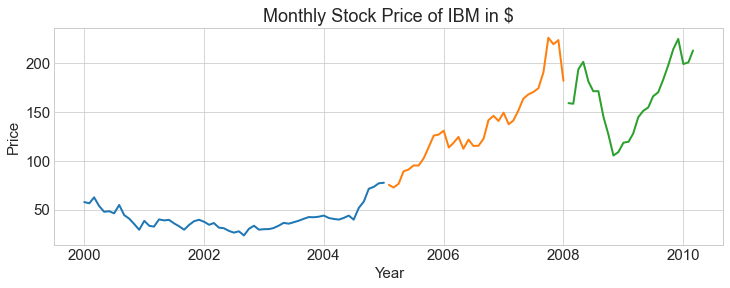

In [54]:
plt.figure(figsize=(12,4))
plt.plot(train['price'])
plt.plot(validate['price'])
plt.plot(test['price'])
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Monthly Stock Price of IBM in $')
plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

```evaluate()``` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.

In [55]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

```plot_and_eval()``` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance.

In [57]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write ```append_eval_df(model_type)``` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our ```eval_df``` data frame object. Which we will create an empty ```eval_df``` dataframe object to start.

In [58]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [60]:
#eval_df

## Forecast
Forecasting is another word for predicting time series data.

1. Last Observed Value
2. Simple Average
3. Moving Average
4. Holt's Linear Trend
5. Previous Cycle

### Last observed value
The simplest method for forecasting is to predict all future values to be the last observed value.

**Make Predictions with last observed value**

Price

In [61]:
price = round(train['price'][-1:][0], 2)
price

77.56

In [64]:
yhat_df = pd.DataFrame({'price': [price]}, 
                      index = validate.index)

yhat_df.head()
yhat_df.describe()

,price
count,3.600000e+01
mean,7.756000e+01
std,4.323731e-14
min,7.756000e+01
25%,7.756000e+01
50%,7.756000e+01
75%,7.756000e+01
max,7.756000e+01


You can see, when peeking into yhat_df, that every predicted value is the same.

**Plot Actual vs. Predicted Values**

price -- RMSE: 70


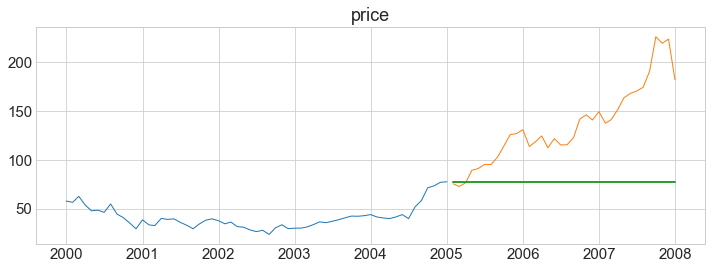

In [65]:
plot_and_eval('price')

Well, that's quite an unhelpful prediction!

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to ```eval_df```

In [66]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'price')
eval_df

,model_type,target_var,rmse
0,last_observed_value,price,70.0


### Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

Price: establishing the value of the prediction we will make

In [67]:
# compute simple average

# plt.plot(train['price'])
price = round(train['price'].mean(),2)
price

41.28

Apply predictions to our observations

In [69]:
yhat_df = pd.DataFrame({'price': [price]}, 
                      index = validate.index)

yhat_df.head()

,price
date,
2005-02-01,41.28
2005-03-01,41.28
2005-04-01,41.28
2005-05-01,41.28
2005-06-01,41.28


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**